# Price the following 3 things via MonteCarlo price in Python

All 1yr maturity

USDJPY 

1. USD call JPY put   Strike = 130       Price in % USD


2. USD call JPY put   Strike = 130   where payout is based on the average of spot over the year (so payout is  Max(Average(spot) – 130,0)*Notional     and that is paid in JPY (natural payout))     Average here is a simple arithmetic Average [ie   1/n*Sum{1=1 to n} S(i) ]   where S(i) is spot on day_i


3. USD call JPY put   Strike = 130 Digital option  :   ie  pays a fixed amount of USD if Spot > 130 at maturity  else it pays 0  

In all cases, assume a Notional of $100,000,000   (though I’m looking for % of USD Notional  answers so it won’t matter)

 

Assume :

USDJPY (Jpy per USD) spot :  132

USD interest rates : 4%


JPY interest rates  : 0.5%

Volatility =   15%

 

Verify #1   by replicating in Python  via the closed form BlackScholes formula.

In [91]:
# Import All Necessary Packages

import numpy as np

import pandas as pd

from random import random

from scipy.stats import norm

import matplotlib.pyplot as plt

import matplotlib.ticker as mtick

import datetime

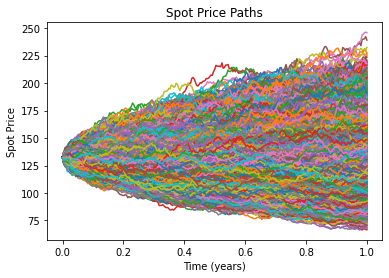

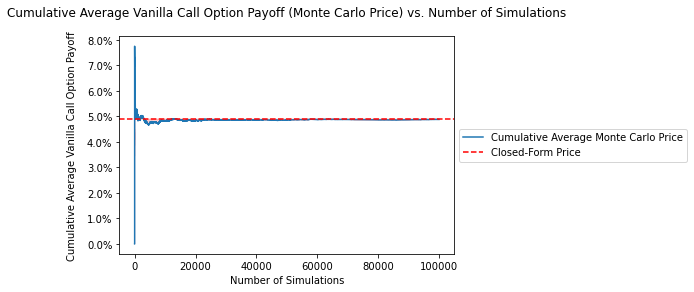

Monte Carlo Vanilla Call Price: 4.8781%


Closed-Form Price: 4.8940%


Difference (MC vs. B/S): -0.0159%




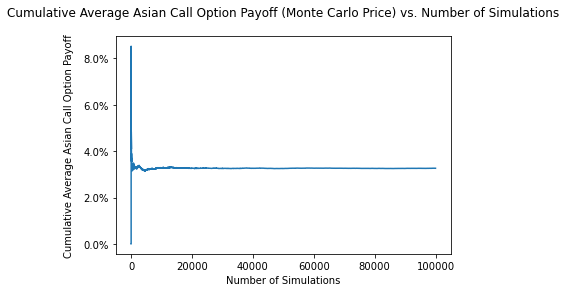

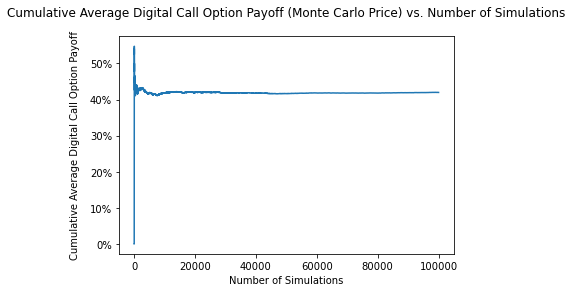

Realized Vol: 15.00%


Time taken: 5372.780534 seconds


,Monte Carlo Prices (% USD),Std Dev
Vanilla Call Monte Carlo Payoff (% USD),4.8781%,8.5310%
Asian Call Monte Carlo Payoff (% USD),3.2631%,5.1617%
Digital Call Monte Carlo Payoff (% USD),41.9650%,49.3504%


In [104]:
# Define Option Pricer

def option_pricer_1(choose = 0):
    
    """
    
    This option pricer either runs
    
        a) Using the assumptions given for the assignment (Various USD/JPY calls) or...
        
        b) Allows the user to input the parameters to price the option
        
    The pricer uses Monte Carlo simulation to calculate the payoffs of
        
        a) Vanilla
        
        b) Asian
        
        c) Digital FX derivatives
    
    for both calls and puts in % USD (CCY1%).
    
    For vanilla options the pricer compares the Monte Carlo simulated price to the Black & Scholes closed-form price
    
    There are multiple charts outputted.
    
    The first chart shows the spot price paths over the stated maturity for the number of simulations
    
    The charts that follow show the cumulative average payoffs for each option type over the number of simulations.
    
    For vanilla options, the green shading represents the option price is above the closed-form price and the red
    shading represents the option price is below the closed-form price.
    
    The other charts represent the cumulative average payoffs (Monte-Carlo price) for asian and digital options.
    
    Finally, the function returns a table (dataframe) of the Monte-Carlo prices for each option type and their
    standard deviations
    
    """
    
    
    
    # Choose is predefined in function as 0 (Assumptions are preset)
    
    if choose == 0:

        k = 130

        notional = 100_000_000

        s_initial = 132

        t = 1

        r_usd = 0.04

        r_jpy = 0.005

        vol = 0.15

        pay_direct = 1

        n_sim = 100_000

    # If 1 is inputted, input parameters manually

    elif choose == 1:

        print('Option Parameters')

        print('\n')

        k = float(input("Enter the Strike Price: "))

        notional = float(input("Enter the Notional: "))

        print('\n')

        print('Simulation Parameters: ')

        print('\n')

        s_initial = float(input("Enter the Spot Price: "))

        t = int(input("Enter the Maturity: "))

        r_usd = float(input("Enter the USD Interest Rate: "))

        r_jpy = float(input("Enter the JPY Interest Rate: "))

        vol = float(input("Enter the Volatility: "))

        while True:
            pay_direct = int(input("Enter Payoff Direction (1 for call, -1 for put): "))

            if pay_direct == 1:

                break

            elif pay_direct == -1:

                break

            else:
                print("Invalid input. Please enter either 1 or -1.")

        n_sim = int(input("Enter the Number of Runs: "))

    else:

        print("Invalid input. Please enter either 0 or 1.")
   

    # Calculate the time step
    
    Delta_t = 1/252
    
    # Calculate the number of time steps
    
    N = t * 252
    
    
    # Generate a time axis
    
    t_axis = np.linspace(0, t, N+1)
    
    spot_prices = np.zeros(N+1)
    spot_prices[0] = s_initial
    
    
    # Initialize arrays equal to the number of simulations
    
    spot_mat_list = []
    
    vanilla_call_payoffs = np.zeros(n_sim)
    vanilla_put_payoffs = np.zeros(n_sim)
    
    asian_call_payoffs = np.zeros(n_sim)
    asian_put_payoffs = np.zeros(n_sim)
    
    digital_call_payoffs = np.zeros(n_sim)
    digital_put_payoffs = np.zeros(n_sim)
    
    # Start time tracker
    
    time_start = datetime.datetime.now()
    
    #Start Counter
    
    count = 0
    
    log_returns = []
    
    while count < n_sim:
        
    # Calculate and plot spot price paths

        for i in range(N):
            
            z = norm.ppf(random())  # Get a random value from a standard normal distribution
            spot_prices[i+1] = spot_prices[i] * np.exp((r_jpy - r_usd - 0.5 * vol ** 2) * Delta_t + vol * np.sqrt(Delta_t) * z)
        
        plt.plot(t_axis, spot_prices)
        
    # Calculate log-return of spots
    
        for j in range(1, len(spot_prices)):
            
            log_return = np.log(spot_prices[j]/spot_prices[j-1])
            log_returns.append(log_return)

    # Index Spot at Maturity
        
        spot_mat = spot_prices[-1]
        spot_mat_list.append(spot_mat)


    # 1. Calculate Vanilla Payoffs
    
        # a) Vanilla Call Payoff (CCY1%)
        
        van_call_pay = np.exp(-r_jpy * t) * max((spot_mat - k), 0) / s_initial # Calculate vanilla call payoff (% USD)
        
        vanilla_call_payoffs[count - 1] = van_call_pay # Store vanilla call payoff in array
        
        # b) Vanilla Put Payoff (CCY1%)
        
        van_put_pay = np.exp(-r_jpy * t) * max((k - spot_mat), 0) / s_initial # Calculate vanilla put payoff (% USD)
        
        vanilla_put_payoffs[count - 1] = van_put_pay # Store vanilla put payoff in array
        
    # 2. Calculate Asian Payoffs
    
        avg_spot = sum(spot_prices) / len(spot_prices) # Calculate average spot over period
        
        # a) Asian Call Payoff (CCY1%)
        
        asian_call_pay = max(avg_spot - k, 0) / s_initial # Calculate asian call payoff (% USD)
        
        asian_call_payoffs[count - 1] = asian_call_pay # Store asian call payoff in array
        
        # b) Asian Put Payoff (CCY1%)
        
        asian_put_pay = max(k - avg_spot, 0) / s_initial # Calculate asian put payoff (% USD)
        
        asian_put_payoffs[count - 1] = asian_put_pay # Store asian put payoff in array
        
    #3. Calculate Digital Payoffs
    
        # a) Digital Call Payoff (CCY1%)
        
        if spot_mat > k:
            
            digi_call_pay = 1 # Return = 100% if spot at maturity > strike
        
        else:
            
            digi_call_pay = 0 # Return = 0% if spot at maturity < strike

        
        digital_call_payoffs[count - 1] = digi_call_pay # Store digital call payoff in array
        
        # b) Digital Put Payoff (CCY1%)
        
        if k > spot_mat:
            
            digi_put_pay = 1 # Return = 100% if strike > spot at maturity
        
        else:
            
            digi_put_pay = 0 # Return = 0% if srike < spot at maturity
            
        
        digital_put_payoffs[count - 1] = digi_put_pay # Store digital put payoff in array
        
        count += 1
        
    # End of While Loop
    
    time_end = datetime.datetime.now()
    
    
    
    # Calculate standard deviation of log returns
        
    std_dev = np.std(log_returns)
    
    
    # Calculate Realized (Annualized) Vol
        
    real_vol = (N)**(1/2) * std_dev
    
    real_vol_f = f"Realized Vol: {real_vol:.2%}"
    
    
    # Count and format time taken to run simulations
    
    time_taken = (time_end - time_start).total_seconds()
    
    t_sec = f'Time taken: {time_taken} seconds'

    
    # Outputs for Vanilla Payoffs (Used to compare to closed-form in output)
    
    avg_vanilla_call_payoff = np.mean(vanilla_call_payoffs)
    
    avg_vanilla_put_payoff = np.mean(vanilla_put_payoffs)
    

    # Formatted vanilla payoffs
    
    MC_van_call_price = f'Monte Carlo Vanilla Call Price: {avg_vanilla_call_payoff:.4%}'
    
    MC_van_put_price = f'Monte Carlo Vanilla Put Price: {avg_vanilla_put_payoff:.4%}'
    
    
    # Plot the spot price paths
    
    plt.xlabel('Time (years)')
    
    plt.ylabel('Spot Price')
    
    plt.title('Spot Price Paths')
    
    plt.show()

    
    # Closed-form Black and Scholes 
    
    d1 = (np.log(s_initial / k) + (r_jpy - r_usd + 0.5 * vol**2) * t) / (vol * np.sqrt(t))
    
    d2 = d1 - (vol * t**2)
    
    
    # Calculate the following if the simulation is for calls
    
    if pay_direct == 1:
        
    # Calculate closed-form price and difference
        
        option_price = (s_initial * np.exp(-r_usd * t) * norm.cdf(d1) - k * np.exp(-r_jpy * t) * norm.cdf(d2))
        
        cf_price = option_price / s_initial
        cf_price_f = f'Closed-Form Price: {cf_price:.4%}'
        
        diff = avg_vanilla_call_payoff - cf_price # Difference between Monte Carlo and closed-form prices
        diff_f = f'Difference (MC vs. B/S): {diff:.4%}'
        
    
    # Calculate cumulative average of call option payoffs over the number of simulations  
        
        vc_cumulative_average = np.cumsum(vanilla_call_payoffs) / np.arange(1, n_sim+1)
        
        ac_cumulative_average = np.cumsum(asian_call_payoffs) / np.arange(1, n_sim+1)
        
        dc_cumulative_average = np.cumsum(digital_call_payoffs) / np.arange(1, n_sim+1)
        
    
    # Create a line chart that shows the cumulative average vanilla call option payoff over the number of simulations
    
        fig, ax = plt.subplots()

        plt.plot(vc_cumulative_average, label = 'Cumulative Average Monte Carlo Price')
        plt.axhline(y = cf_price, color = 'r', linestyle = '--', label = 'Closed-Form Price')
        
        plt.legend(loc = 'center left', bbox_to_anchor = (1, 0.5))
        
        plt.xlabel('Number of Simulations')
        plt.ylabel('Cumulative Average Vanilla Call Option Payoff', labelpad = 10)
        
        plt.fill_between(range(n_sim), vc_cumulative_average, cf_price, where = vc_cumulative_average > cf_price, interpolate = True, color = 'green', alpha = 0.2)
        plt.fill_between(range(n_sim), vc_cumulative_average, cf_price, where = vc_cumulative_average < cf_price, interpolate = True, color = 'red', alpha = 0.2)
        
        plt.title('Cumulative Average Vanilla Call Option Payoff (Monte Carlo Price) vs. Number of Simulations', pad = 20)
    
    # Format y-axis as percentage

        ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))

        plt.show()

    # Print Closed-form price and difference
        
        print(MC_van_call_price) # Formatted Monte-Carlo vanilla call price
        
        print('\n')
        
        print(cf_price_f) # Closed-form B/S Price (In .4%)
        
        print('\n')
        
        print(diff_f) # Difference between closed-form B/S and Monte Carlo Price
        
        print('\n')
    
    
    # Create a line chart that shows the cumulative average asian call option payoff over the number of simulations
    
        fig, ax = plt.subplots()

        plt.plot(ac_cumulative_average)
        
        plt.xlabel('Number of Simulations')
        plt.ylabel('Cumulative Average Asian Call Option Payoff', labelpad = 10)
        
        plt.title('Cumulative Average Asian Call Option Payoff (Monte Carlo Price) vs. Number of Simulations', pad = 20)
    
    # Format y-axis as percentage
    
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))

        plt.show()
    
    
    # Create a line chart that shows the cumulative average digital call option payoff over the number of simulations
    
        fig, ax = plt.subplots()

        plt.plot(dc_cumulative_average)
        
        plt.xlabel('Number of Simulations')
        plt.ylabel('Cumulative Average Digital Call Option Payoff', labelpad = 10)
        
        plt.title('Cumulative Average Digital Call Option Payoff (Monte Carlo Price) vs. Number of Simulations', pad = 20)

    # Format y-axis as a percentage
        
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))

        plt.show()
        
    
    # Create a dictionary to store the payoffs for each Call option type
    
        payoffs = {
            'Vanilla Call Monte Carlo Payoff (% USD)': vanilla_call_payoffs,
            'Asian Call Monte Carlo Payoff (% USD)': asian_call_payoffs,
            'Digital Call Monte Carlo Payoff (% USD)': digital_call_payoffs,
        }
    
    
    # Calculate the following if the simulation is for puts
    
    elif pay_direct == -1:
        
    # Calculate closed-form price and difference
        
        option_price = (k * np.exp(-r_jpy * t) * norm.cdf(-d2) - s_initial * np.exp(-r_usd * t) * norm.cdf(-d1))
        
        cf_price = option_price / s_initial
        cf_price_f = f'Closed-Form Price: {cf_price:.4%}'
        
        diff = avg_vanilla_put_payoff - cf_price # Difference between Monte Carlo and closed-form prices
        diff_f = f'Difference (MC vs. B/S): {diff:.4%}'
        
    
    # Calculate cumulative average of put option payoffs over the number of simulations
        
        vp_cumulative_average = np.cumsum(vanilla_put_payoffs) / np.arange(1, n_sim+1)
        
        ap_cumulative_average = np.cumsum(asian_put_payoffs) / np.arange(1, n_sim+1)
        
        dp_cumulative_average = np.cumsum(digital_put_payoffs) / np.arange(1, n_sim+1)
        
    
    # Create a line chart that shows the cumulative average vanilla put option payoff over the number of simulations
    
        fig, ax = plt.subplots()

        plt.plot(vp_cumulative_average, label = 'Cumulative Average Monte Carlo Price')
        plt.axhline(y = cf_price, color = 'r', linestyle = '--', label = 'Closed-Form Price')
        
        plt.legend(loc = 'center left', bbox_to_anchor = (1, 0.5))
        
        plt.xlabel('Number of Simulations')
        plt.ylabel('Cumulative Average Vanilla Put Option Payoff', labelpad = 10)
        
        plt.fill_between(range(n_sim), vp_cumulative_average, cf_price, where = vp_cumulative_average > cf_price, interpolate = True, color = 'green', alpha = 0.2)
        plt.fill_between(range(n_sim), vp_cumulative_average, cf_price, where = vp_cumulative_average < cf_price, interpolate = True, color = 'red', alpha = 0.2)
        
        plt.title('Cumulative Average Vanilla Put Option Payoff (Monte Carlo Price) vs. Number of Simulations', pad = 20)
        
    # Format y-axis as percentage

        ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))

        plt.show()
        
    # Print Closed-form price and difference

        print(MC_van_put_price) # Formatted Monte-Carlo vanilla put price
        
        print('\n')
        
        print(cf_price_f) # Closed-form B/S Price (In .4%)
        
        print('\n')
        
        print(diff_f) # Difference between closed-form B/S and Monte Carlo Price
        
        print('\n')
        
    
    # Create a line chart that shows the cumulative average asian put option payoff over the number of simulations
    
        fig, ax = plt.subplots()

        plt.plot(ap_cumulative_average)
        
        plt.xlabel('Number of Simulations')
        plt.ylabel('Cumulative Average Asian Put Option Payoff', labelpad = 10)
        
        plt.title('Cumulative Average Asian Put Option Payoff (Monte Carlo Price) vs. Number of Simulations', pad = 20)
        
    # Format y-axis as percentage
    
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))

        plt.show()
        
    
    # Create a line chart that shows the cumulative average digital put option payoff over the number of simulations
    
        fig, ax = plt.subplots()

        plt.plot(dp_cumulative_average)
        
        plt.xlabel('Number of Simulations')
        plt.ylabel('Cumulative Average Digital Put Option Payoff', labelpad = 10)
        
        plt.title('Cumulative Average Digital Put Option Payoff (Monte Carlo Price) vs. Number of Simulations', pad = 20)

    # Format y-axis as a percentage
        
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))

        plt.show()
        
    
    # Create a dictioinary to store the payoffs for each Put option type
    
        payoffs = {
            'Vanilla Put Monte Carlo Payoff (% USD)': vanilla_put_payoffs,
            'Asian Put Monte Carlo Payoff (% USD)': asian_put_payoffs,
            'Digital Put Monte Carlo Payoff (% USD)': digital_put_payoffs
        }
        
    # End of if statement
    

    # Create a DataFrame to store the payoffs
    
    df = pd.DataFrame(payoffs)

    
    # Calculate the mean and standard deviation of each option type
    
    statistics = pd.DataFrame({
        'Monte Carlo Prices (% USD)': df.mean(),
        'Std Dev': df.std()
    })
    
    
    # Store the formatted data frame in MC_prices
    
    MC_prices = statistics.style.format('{:.4%}')

    
    # Print Relevant Stats
    
    print(real_vol_f) # Realized vol should be similar to input vol
    
    print('\n')
    
    print(t_sec) # Time taken to run the simulation
    
    return MC_prices
    
option_pricer_1()

## End of Unit Code